In [1]:
import bn
import ocr_data_highres as ocr_data
import numpy as np
from IPython.display import clear_output
from importlib import reload
reload(bn)

<module 'bn' from '/home/benland100/Desktop/bn/bn.py'>

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,7]
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['font.size'] = 19
matplotlib.rcParams['font.family'] = 'DejaVu Serif'
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams['errorbar.capsize'] = 3

In [3]:
input_shape = ocr_data.in_2d_shape
conv_kernels = [(8,8),(4,4)]
conv_stride = [(4,4),(1,1)]
conv_outs = [(8,),(8,)]
conv_layers = len(conv_kernels)
hidden_shapes = [(10,10)]
hidden_layers = len(hidden_shapes)
output_shape = ocr_data.out_shape
print(input_shape,output_shape)

(32, 32) (26,)


In [4]:
layers = []
layers.append(bn.Input(input_shape))
for kernel_shape,out_shape,kernel_stride in zip(conv_kernels,conv_outs,conv_stride):
    layers.append(bn.Conv(kernel_shape,out_shape=out_shape,kernel_stride=kernel_stride))
for hidden_shape in hidden_shapes:
    layers.append(bn.Dense(hidden_shape))
layers.append(bn.Output(output_shape))

s = bn.System()
insts = []
inputs = None
for layer in layers:
    insts.append(layer.construct(s,inputs))
    inputs = insts[-1].outputs
    print(layer, inputs.shape)
s.finalize()

<bn.Input object at 0x7f1bef994160> (32, 32)
<bn.Conv object at 0x7f1bec097070> (7, 7, 8)
<bn.Conv object at 0x7f1bec097940> (4, 4, 8)
<bn.Dense object at 0x7f1bec097880> (10, 10)
<bn.Output object at 0x7f1bef9945e0> (26,)


In [5]:
print('IN: %s OUT: %s TOTAL: %i WEIGHTS: %i'%(input_shape,output_shape,len(s.neurons),np.sum([len(n.weights) for n in s.neurons])))

IN: (32, 32) OUT: (26,) TOTAL: 1670 WEIGHTS: 56872


In [6]:
import multiprocessing
import functools

def worker(args):
    true_out,input = args
    guess_out,state = s.guess(input,return_state=True)
    if np.any(guess_out != true_out):
        deltas = s.learn(state,true_out,batch=True,scale=1.0)
    else:
        deltas = None
    return deltas

def s_batch(length):
    total = 0
    failures = 0
    state = None
    for true_out,input in ocr_data.tagged_data(length):
        guess_out,state = s.guess(input,return_state=True)
        if np.any(guess_out != true_out):
            failures += 1
            s.learn(state,true_out,scale=1.0)
        total += 1
    return total,failures

def mp_batch(length,chunk_size,max_pool_size=10):
    pool_size = min(chunk_size,max_pool_size)
    total,failures = 0,0
    while total < length:
        size = min(chunk_size,length-total)
        try:
            p = multiprocessing.Pool(pool_size)
            chunk_deltas = [deltas for deltas in p.map(worker,ocr_data.tagged_data(size)) if deltas is not None]
        except KeyboardInterrupt:
            raise
        finally:
            p.close()
        total += size
        failures += len(chunk_deltas)
        if len(chunk_deltas) > 0:
            s.apply_deltas(chunk_deltas[0],batch=False)
    return total,failures

def batch(length=1000,initial_size=None,min_chunk_size=2):    
    if initial_size is None:
        initial_size = int(length/10)
    total,failures = mp_batch(initial_size,initial_size)
    chunk_size = round(1.2*total/failures) if failures > 0 else total
    if chunk_size < min_chunk_size:
        print('Running Serial Batch')
        sub_t,sub_f = s_batch(length-total)
        return sub_t+total,failures+sub_f
    else:
        print('Using batch chunk_size',chunk_size)
        return mp_batch(length,chunk_size)

In [7]:
%prun batch(10)

Running Serial Batch
 

In [8]:
print('loading weights')
s.load_weights('OCR_conv_hires_better.h5')

In [22]:
try:
    batch_size = 10000
    while True:
        cases,failures = batch(batch_size)
        print('saving weights')
        s.save_weights('OCR_conv_hires_better.h5')
        print('batch accuracy',cases-failures,'/',cases)
        if (cases-failures)/cases > 0.999:
            break
except KeyboardInterrupt:
    print('Stopped by user')

Using batch chunk_size 13
saving weights
batch accuracy 8540 / 10000
Using batch chunk_size 10
saving weights
batch accuracy 8669 / 10000
Using batch chunk_size 8
saving weights
batch accuracy 8924 / 10000
Using batch chunk_size 7
saving weights
batch accuracy 8963 / 10000
Using batch chunk_size 14
saving weights
batch accuracy 9079 / 10000
Using batch chunk_size 13
saving weights
batch accuracy 9052 / 10000
Using batch chunk_size 10
saving weights
batch accuracy 9136 / 10000
Using batch chunk_size 12
saving weights
batch accuracy 9269 / 10000
Using batch chunk_size 13
saving weights
batch accuracy 9288 / 10000
Using batch chunk_size 17
saving weights
batch accuracy 9304 / 10000
Using batch chunk_size 13
saving weights
batch accuracy 9298 / 10000
Using batch chunk_size 26
saving weights
batch accuracy 9343 / 10000
Using batch chunk_size 19
saving weights
batch accuracy 9420 / 10000
Using batch chunk_size 22
saving weights
batch accuracy 9412 / 10000
Using batch chunk_size 24
saving wei

Using batch chunk_size 38
saving weights
batch accuracy 9707 / 10000
Using batch chunk_size 35
saving weights
batch accuracy 9776 / 10000
Using batch chunk_size 40
saving weights
batch accuracy 9776 / 10000
Using batch chunk_size 44
saving weights
batch accuracy 9810 / 10000
Using batch chunk_size 120
saving weights
batch accuracy 9811 / 10000
Using batch chunk_size 39
saving weights
batch accuracy 9800 / 10000
Using batch chunk_size 86
saving weights
batch accuracy 9808 / 10000
Using batch chunk_size 150
saving weights
batch accuracy 9843 / 10000
Using batch chunk_size 75
saving weights
batch accuracy 9794 / 10000
Using batch chunk_size 86
saving weights
batch accuracy 9791 / 10000
Using batch chunk_size 38
saving weights
batch accuracy 9807 / 10000
Using batch chunk_size 109
saving weights
batch accuracy 9834 / 10000
Using batch chunk_size 55
saving weights
batch accuracy 9770 / 10000
Using batch chunk_size 100
saving weights
batch accuracy 9807 / 10000
Using batch chunk_size 100
sav

saving weights
batch accuracy 9860 / 10000
Using batch chunk_size 240
saving weights
batch accuracy 9870 / 10000
Using batch chunk_size 71
saving weights
batch accuracy 9883 / 10000
Using batch chunk_size 133
saving weights
batch accuracy 9884 / 10000
Using batch chunk_size 100
saving weights
batch accuracy 9880 / 10000
Using batch chunk_size 86
saving weights
batch accuracy 9882 / 10000
Using batch chunk_size 100
saving weights
batch accuracy 9903 / 10000
Using batch chunk_size 171
saving weights
batch accuracy 9919 / 10000
Using batch chunk_size 171
saving weights
batch accuracy 9902 / 10000
Using batch chunk_size 63
saving weights
batch accuracy 9896 / 10000
Using batch chunk_size 240
saving weights
batch accuracy 9904 / 10000
Using batch chunk_size 200
saving weights
batch accuracy 9926 / 10000
Using batch chunk_size 200
saving weights
batch accuracy 9888 / 10000
Using batch chunk_size 150
saving weights
batch accuracy 9926 / 10000
Using batch chunk_size 86
saving weights
batch acc

Using batch chunk_size 67
saving weights
batch accuracy 9886 / 10000
Using batch chunk_size 50
saving weights
batch accuracy 9875 / 10000
Using batch chunk_size 71
saving weights
batch accuracy 9872 / 10000
Using batch chunk_size 86
saving weights
batch accuracy 9888 / 10000
Using batch chunk_size 46
saving weights
batch accuracy 9892 / 10000
Using batch chunk_size 150
saving weights
batch accuracy 9876 / 10000
Using batch chunk_size 75
saving weights
batch accuracy 9863 / 10000
Using batch chunk_size 63
saving weights
batch accuracy 9845 / 10000
Using batch chunk_size 109
saving weights
batch accuracy 9862 / 10000
Using batch chunk_size 86
saving weights
batch accuracy 9837 / 10000
Using batch chunk_size 100
saving weights
batch accuracy 9904 / 10000
Using batch chunk_size 92
saving weights
batch accuracy 9880 / 10000
Using batch chunk_size 133
saving weights
batch accuracy 9858 / 10000
Using batch chunk_size 71
saving weights
batch accuracy 9867 / 10000
Using batch chunk_size 75
savi

saving weights
batch accuracy 9579 / 10000
Using batch chunk_size 39
saving weights
batch accuracy 9679 / 10000
Using batch chunk_size 27
saving weights
batch accuracy 9658 / 10000
Using batch chunk_size 35
saving weights
batch accuracy 9480 / 10000
Using batch chunk_size 29
saving weights
batch accuracy 9576 / 10000
Using batch chunk_size 14
saving weights
batch accuracy 9512 / 10000
Using batch chunk_size 28
saving weights
batch accuracy 9648 / 10000
Using batch chunk_size 25
saving weights
batch accuracy 9581 / 10000
Using batch chunk_size 24
saving weights
batch accuracy 9571 / 10000
Using batch chunk_size 32
saving weights
batch accuracy 9558 / 10000
Using batch chunk_size 28
saving weights
batch accuracy 9466 / 10000
Using batch chunk_size 31
saving weights
batch accuracy 9612 / 10000
Using batch chunk_size 33
saving weights
batch accuracy 9591 / 10000
Using batch chunk_size 35
saving weights
batch accuracy 9486 / 10000
Using batch chunk_size 16
saving weights
batch accuracy 9480

saving weights
batch accuracy 9570 / 10000
Using batch chunk_size 32
saving weights
batch accuracy 9556 / 10000
Using batch chunk_size 20
saving weights
batch accuracy 9543 / 10000
Using batch chunk_size 31
saving weights
batch accuracy 9608 / 10000
Using batch chunk_size 52
saving weights
batch accuracy 9639 / 10000
Using batch chunk_size 32
saving weights
batch accuracy 9644 / 10000
Using batch chunk_size 39
saving weights
batch accuracy 9685 / 10000
Using batch chunk_size 52
saving weights
batch accuracy 9700 / 10000
Using batch chunk_size 39
saving weights
batch accuracy 9677 / 10000
Using batch chunk_size 23
saving weights
batch accuracy 9710 / 10000
Using batch chunk_size 39
saving weights
batch accuracy 9679 / 10000
Using batch chunk_size 63
saving weights
batch accuracy 9704 / 10000
Using batch chunk_size 48
saving weights
batch accuracy 9698 / 10000
Using batch chunk_size 39
saving weights
batch accuracy 9709 / 10000
Using batch chunk_size 50
saving weights
batch accuracy 9683

Exception ignored in: Process ForkPoolWorker-1843393:
Process ForkPoolWorker-1843392:
Exception ignored in: <function _releaseLock at 0x7f1bf3cccf70>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
<bound method Random.seed of <random.Random object at 0x55b063afce60>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/random.py", line 152, in seed
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
      File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


Stopped by user


-567.1518501133725


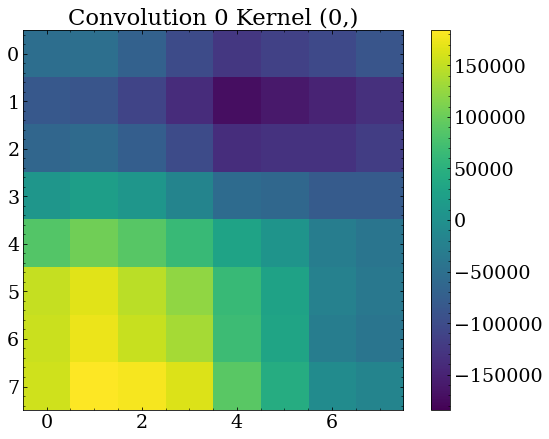

68.77444593706686


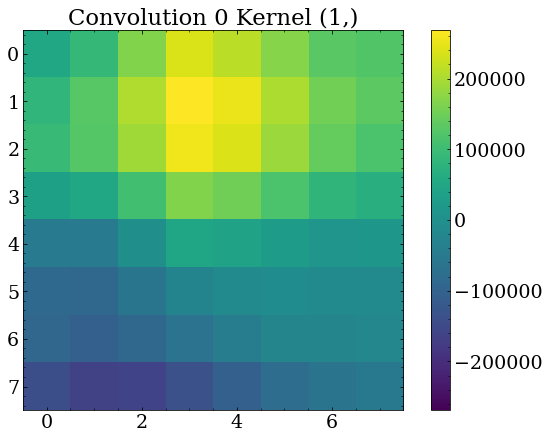

-637.554957740423


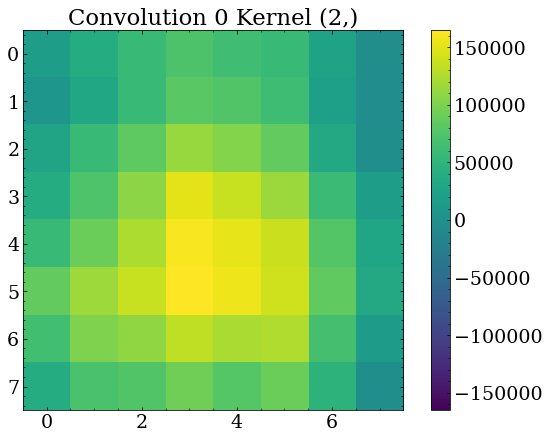

-2.8572460048732378


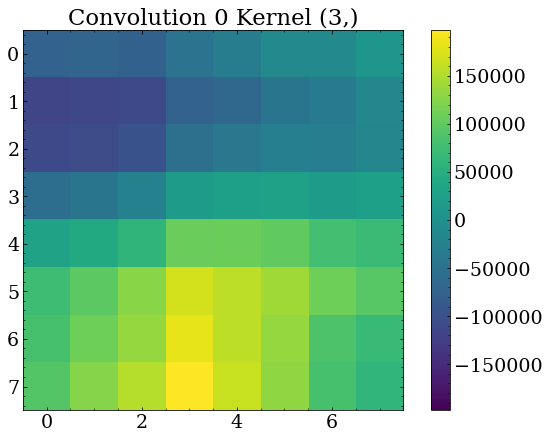

-27.617881001035126


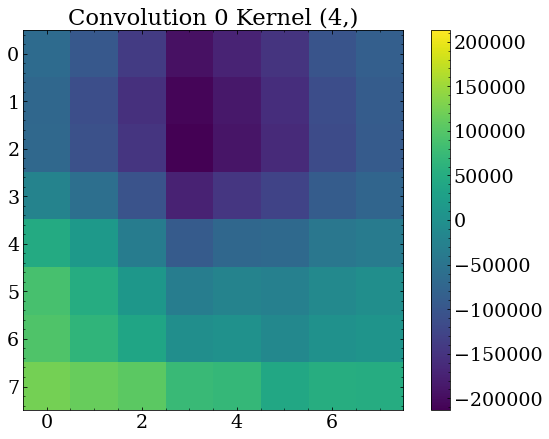

-219.90535483437702


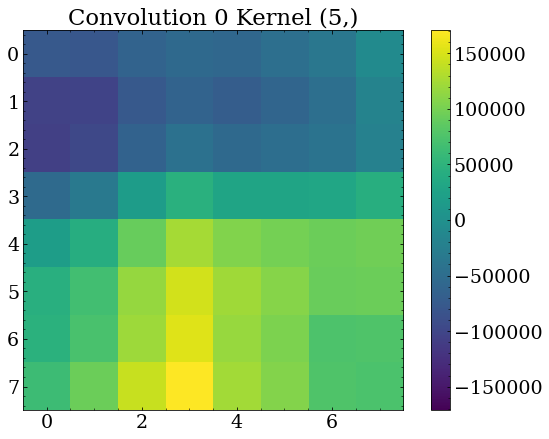

111.06974466532063


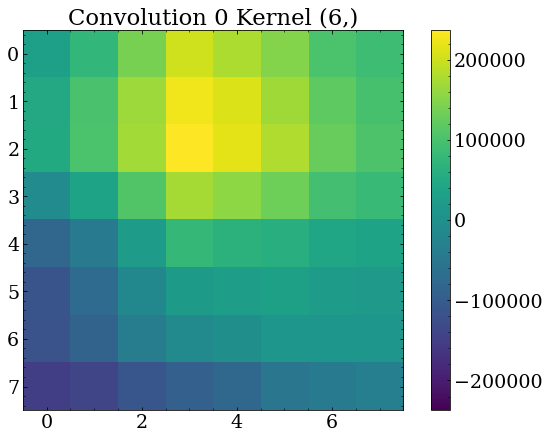

505.22615865052217


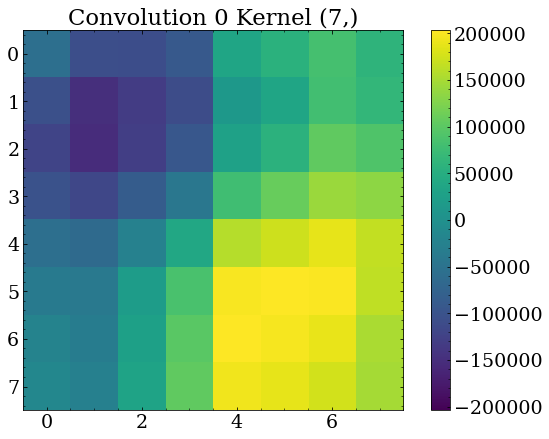

ValueError: cannot reshape array of size 128 into shape (4,4)

In [23]:
from matplotlib.colors import Normalize

for inst,(conv_out,conv_kernel) in enumerate(zip(conv_outs,conv_kernels)):
    for i,index in enumerate(np.ndindex(conv_out)):
        img_conv = insts[inst+1].neurons[i].weights.reshape(conv_kernel)
        print(insts[inst+1].neurons[i].threshold)
        norm = np.max(np.abs(img_conv))
        norm = Normalize(-norm,norm)
        plt.figure()
        plt.title('Convolution %i Kernel %s'%(inst,index))
        plt.imshow(img_conv,norm=norm)
        plt.colorbar()
        plt.show()
        plt.close()

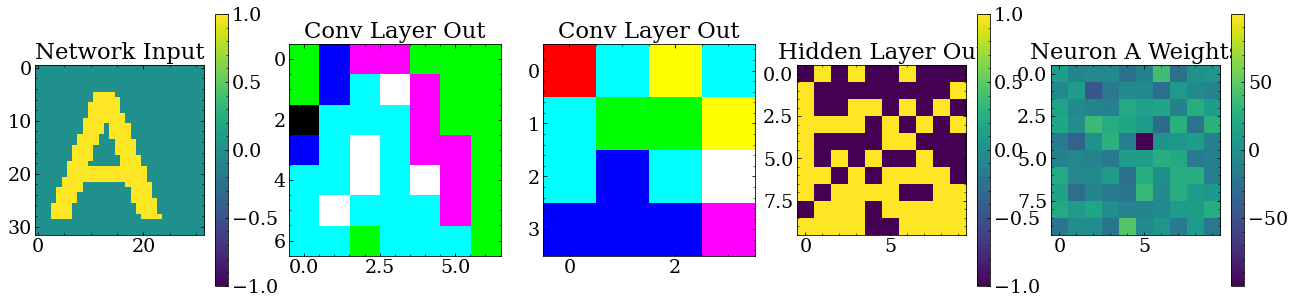

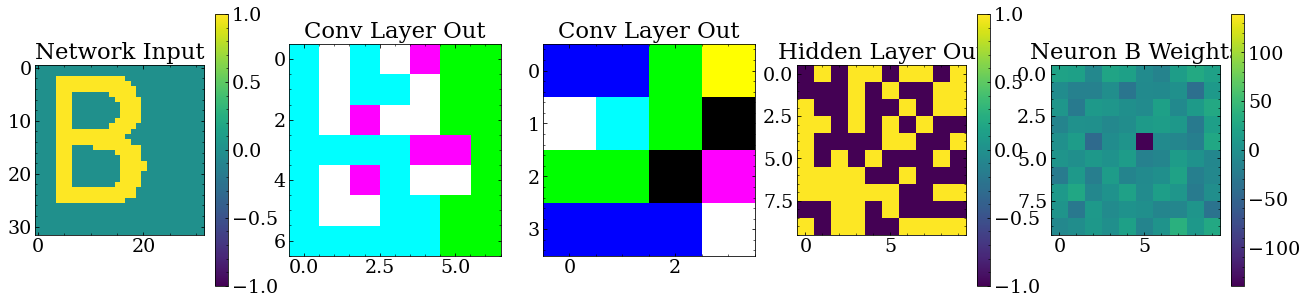

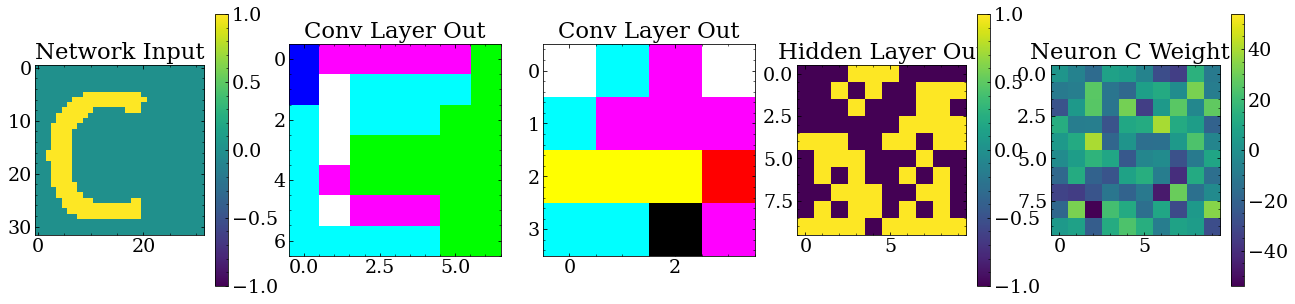

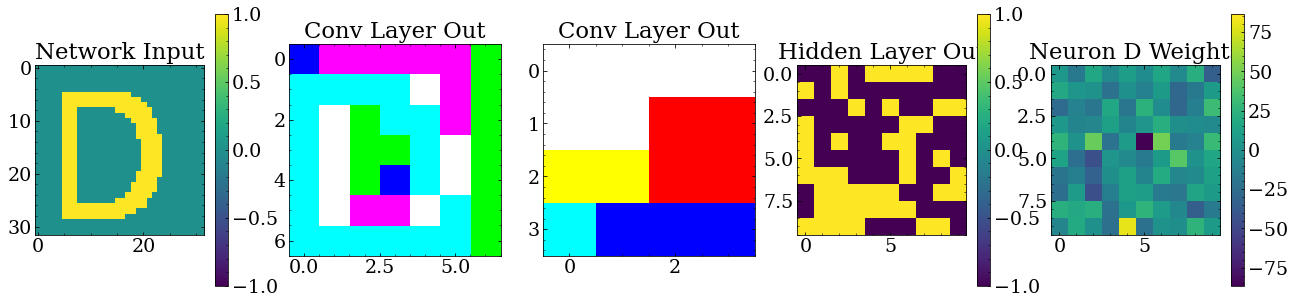

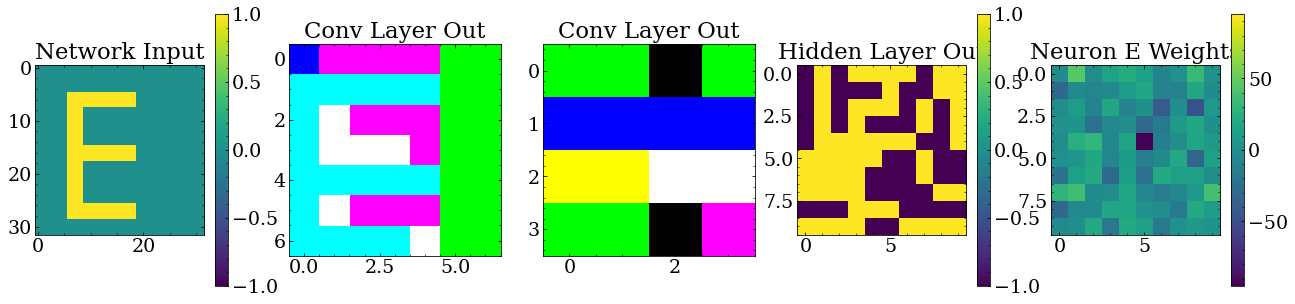

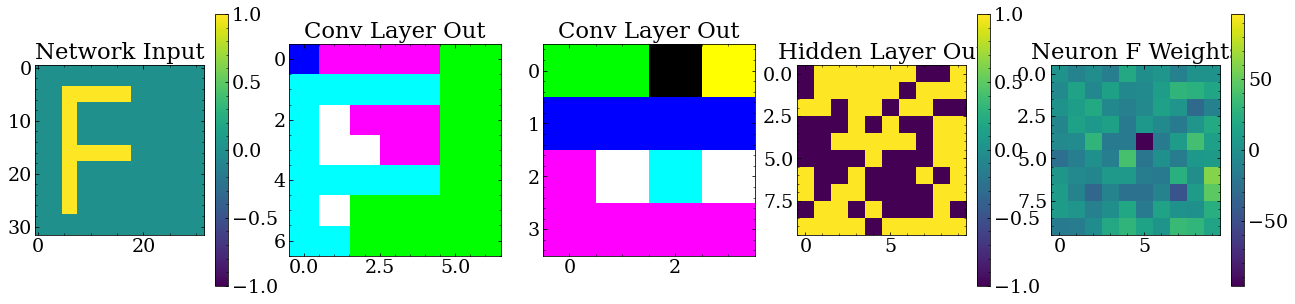

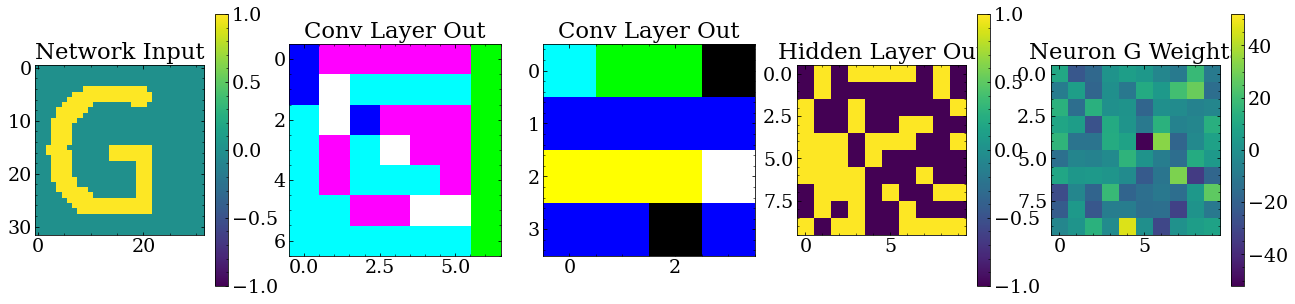

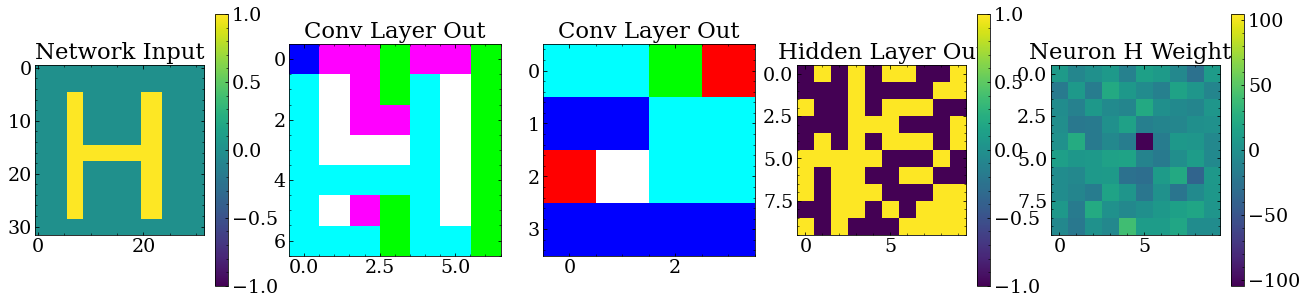

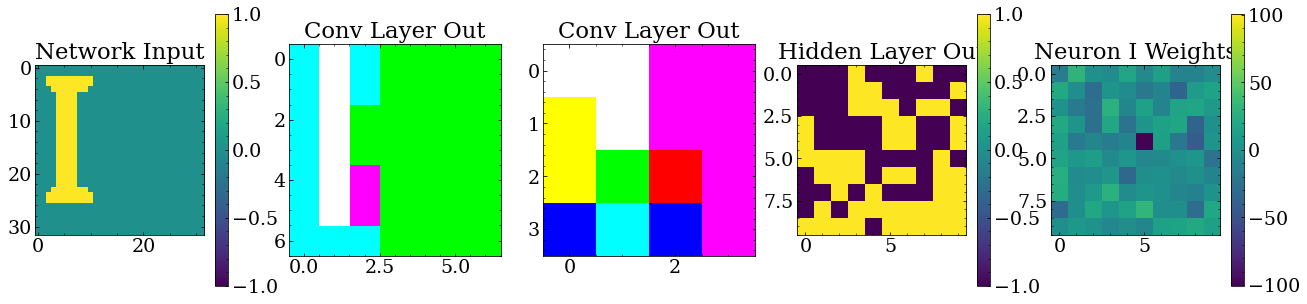

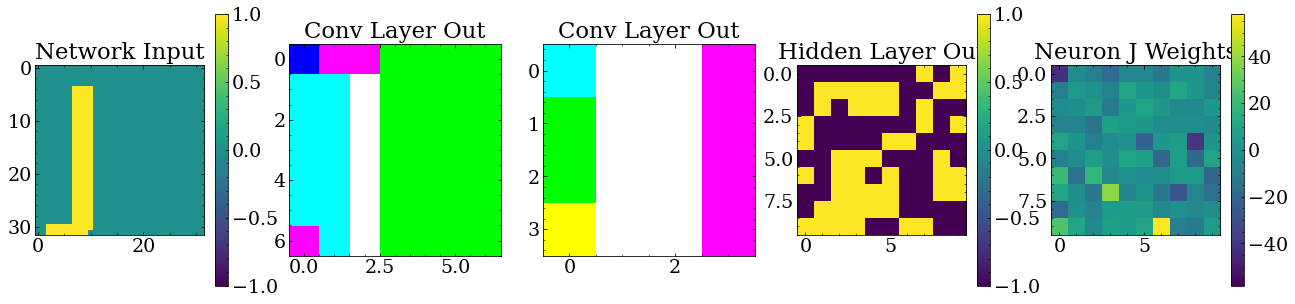

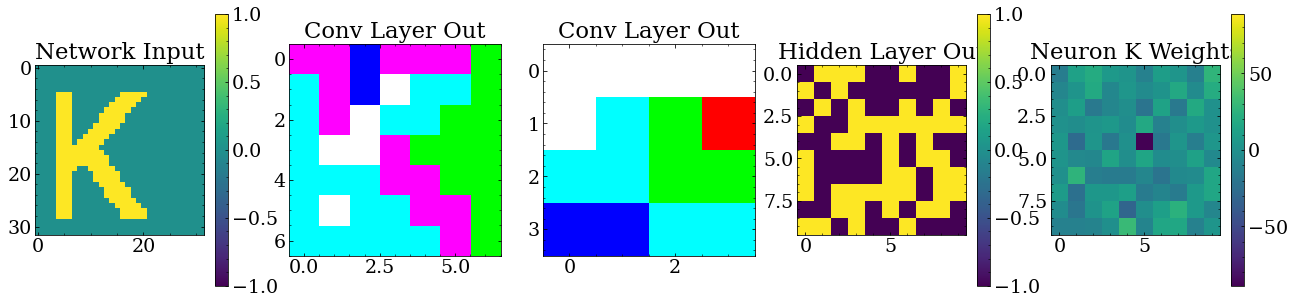

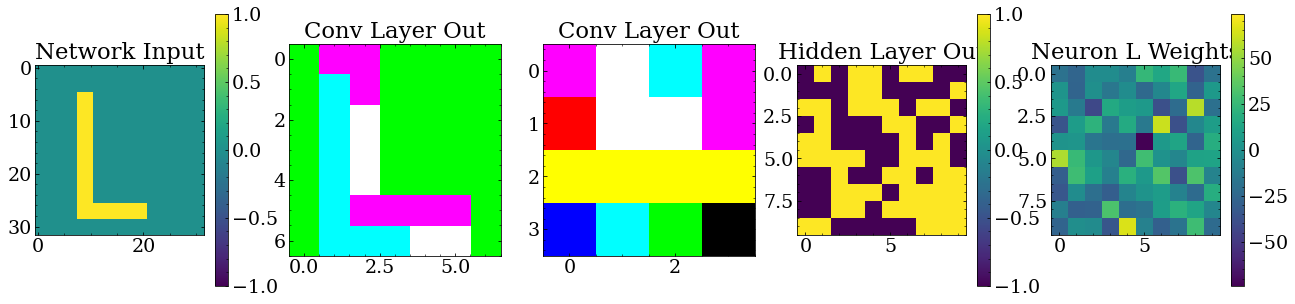

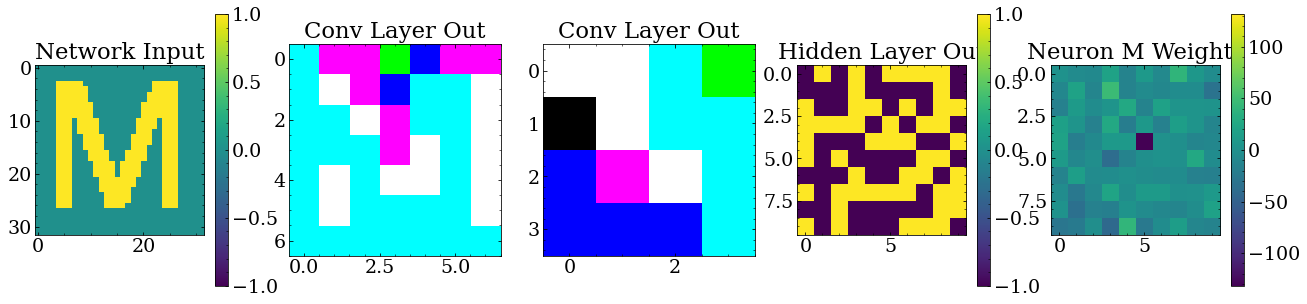

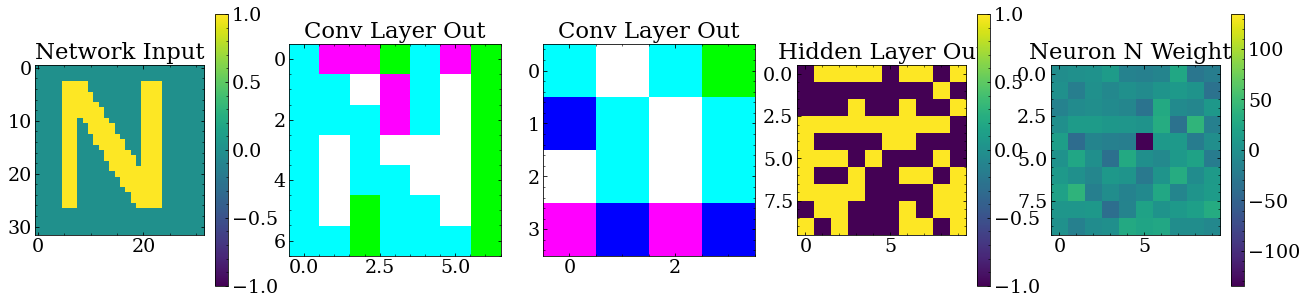

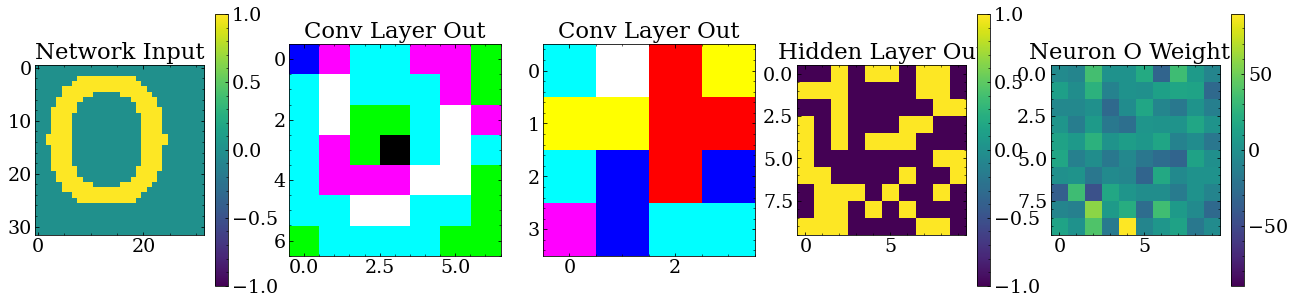

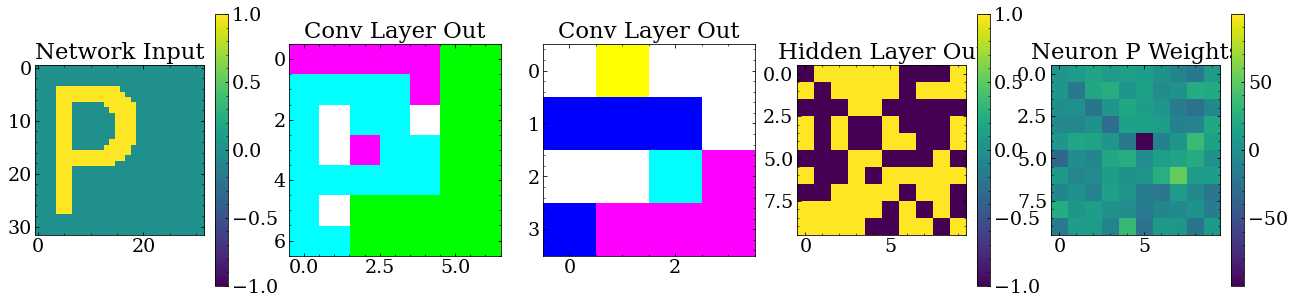

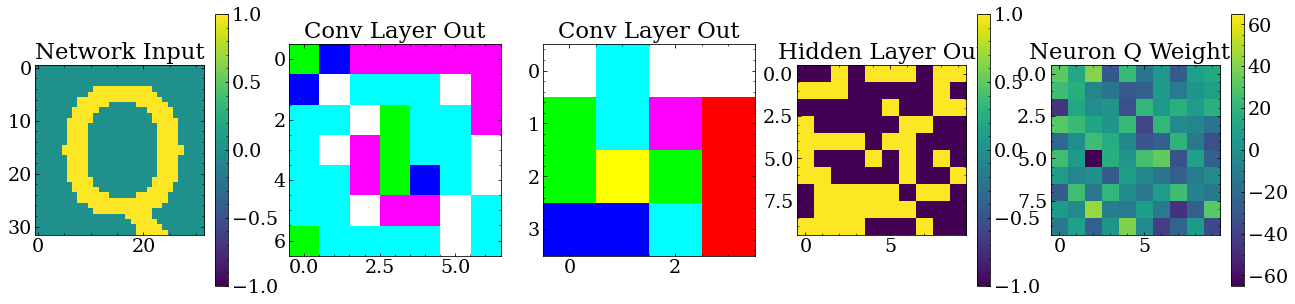

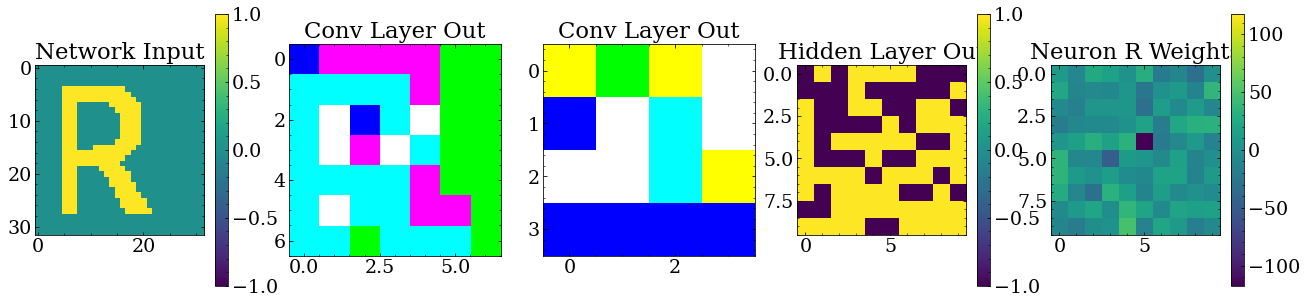

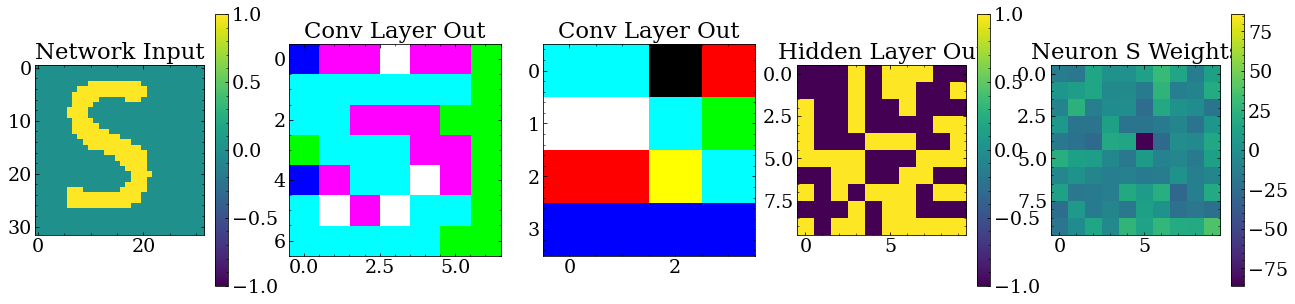

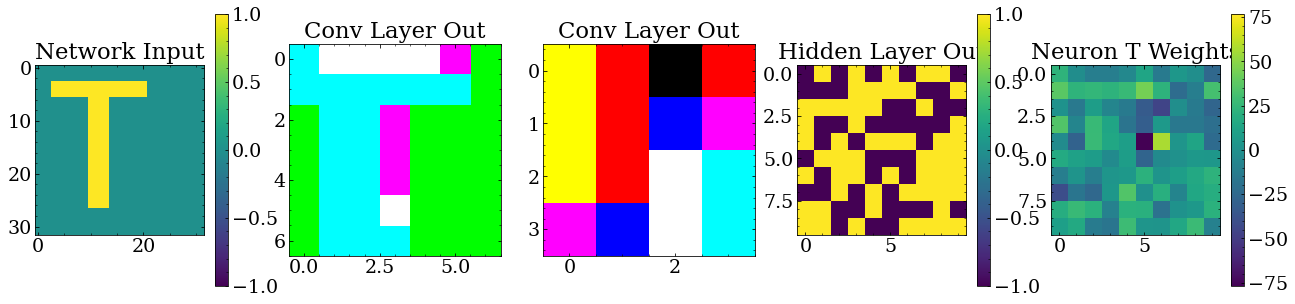

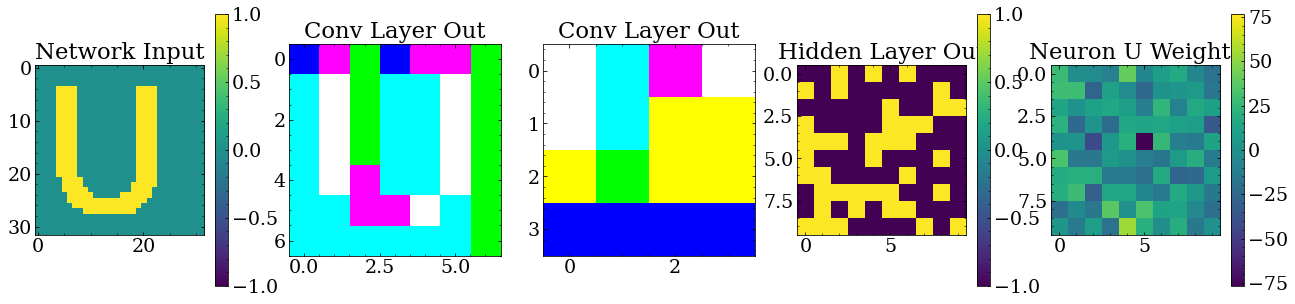

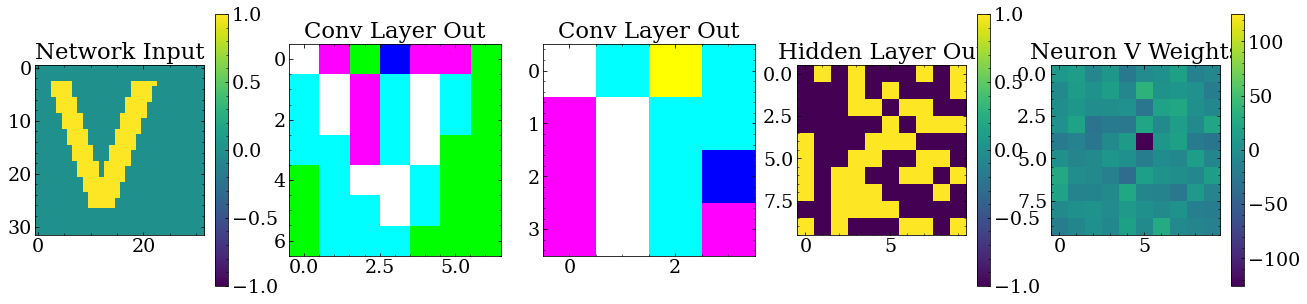

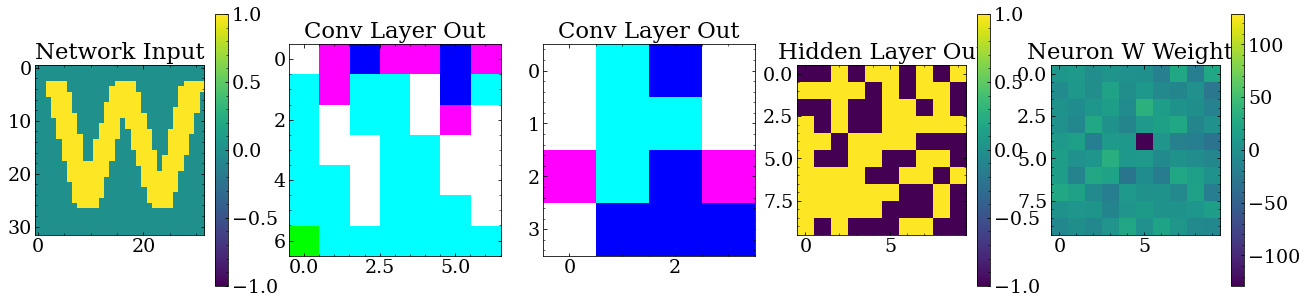

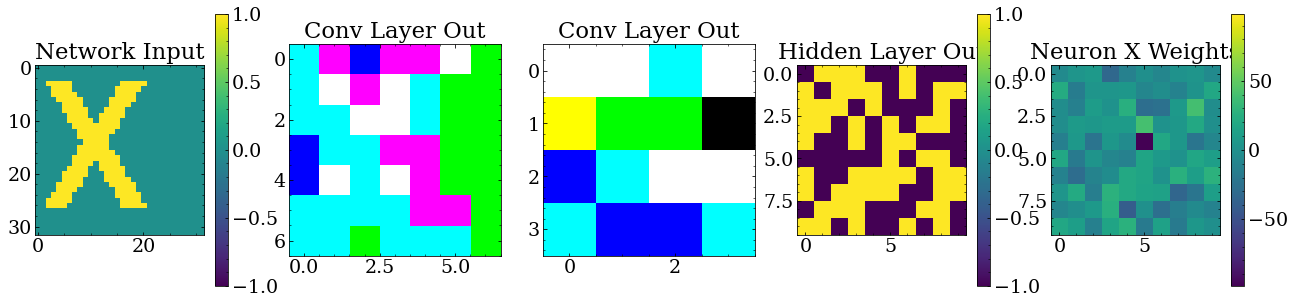

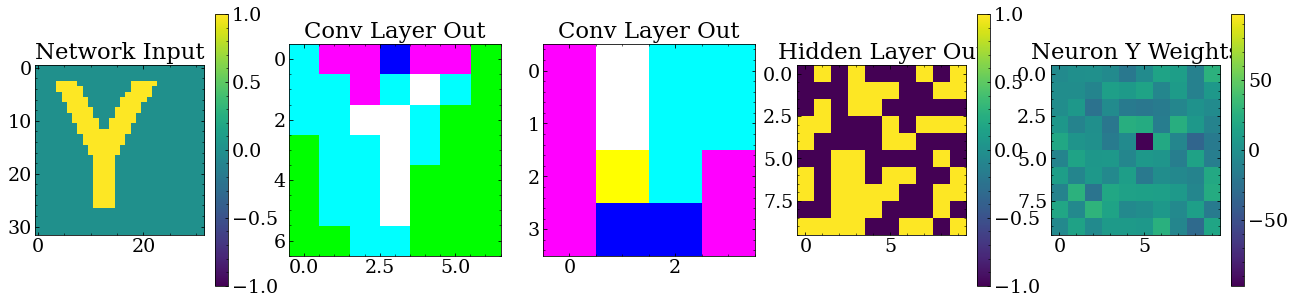

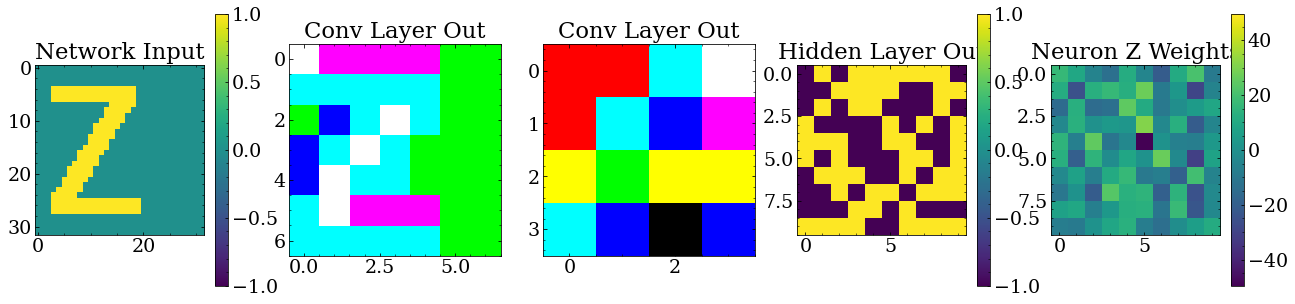

In [24]:
#to plot a simple one hidden layer network

from matplotlib.colors import Normalize

true_norm = Normalize(-1,1)
hidden_shapes = [(5,10)]

for i,iout in enumerate(s.outputs):
    letter = ocr_data.letters[i]
    for trial in range(1):
        test_in = ocr_data.gen_data(letter)[1]


        pltmagic = 100 + 20 + hidden_layers*10 + conv_layers*10
        plt.figure(figsize=[22,5])


        guess_out,state = s.guess(test_in.flatten(),return_state=True)
        inputs = insts[0].get_state(state)

        plt.subplot(pltmagic+1)
        plt.title('Network Input')
        plt.imshow(inputs,norm=true_norm)
        plt.colorbar()

        last_shape = test_in.shape
        for j in range(conv_layers):
            img_hidden = insts[1+j].get_state(state)

            plt.subplot(pltmagic+2+j)
            plt.title('Conv Layer Out')
            plt.imshow((img_hidden[:,:,:3]+1)/2)
            #plt.colorbar()


        for j in range(hidden_layers):
            img_hidden = insts[1+conv_layers+j].get_state(state)

            plt.subplot(pltmagic+2+conv_layers+j)
            plt.title('Hidden Layer Out')
            plt.imshow(img_hidden)
            plt.colorbar()

        plt.subplot(pltmagic+conv_layers+2+hidden_layers)
        plt.title('Neuron ''%s'' Weights'%letter)
        img_weights = insts[-1].neurons[i].weights.reshape(insts[-2].outputs.shape)
        norm = np.max(np.abs(img_weights))
        weight_norm = Normalize(-norm,norm)
        plt.imshow(img_weights,norm=weight_norm)
        plt.colorbar()
        plt.show()
        plt.close()